In [50]:
%matplotlib inline
# import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
# from IPython.display import set_matplotlib_formats

# Plotting setup
# set_matplotlib_formats("pdf", "svg")
plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{amsfonts} \usepackage{amsmath}"


import torch
import torch.nn as nn
import torch.nn.functional as F

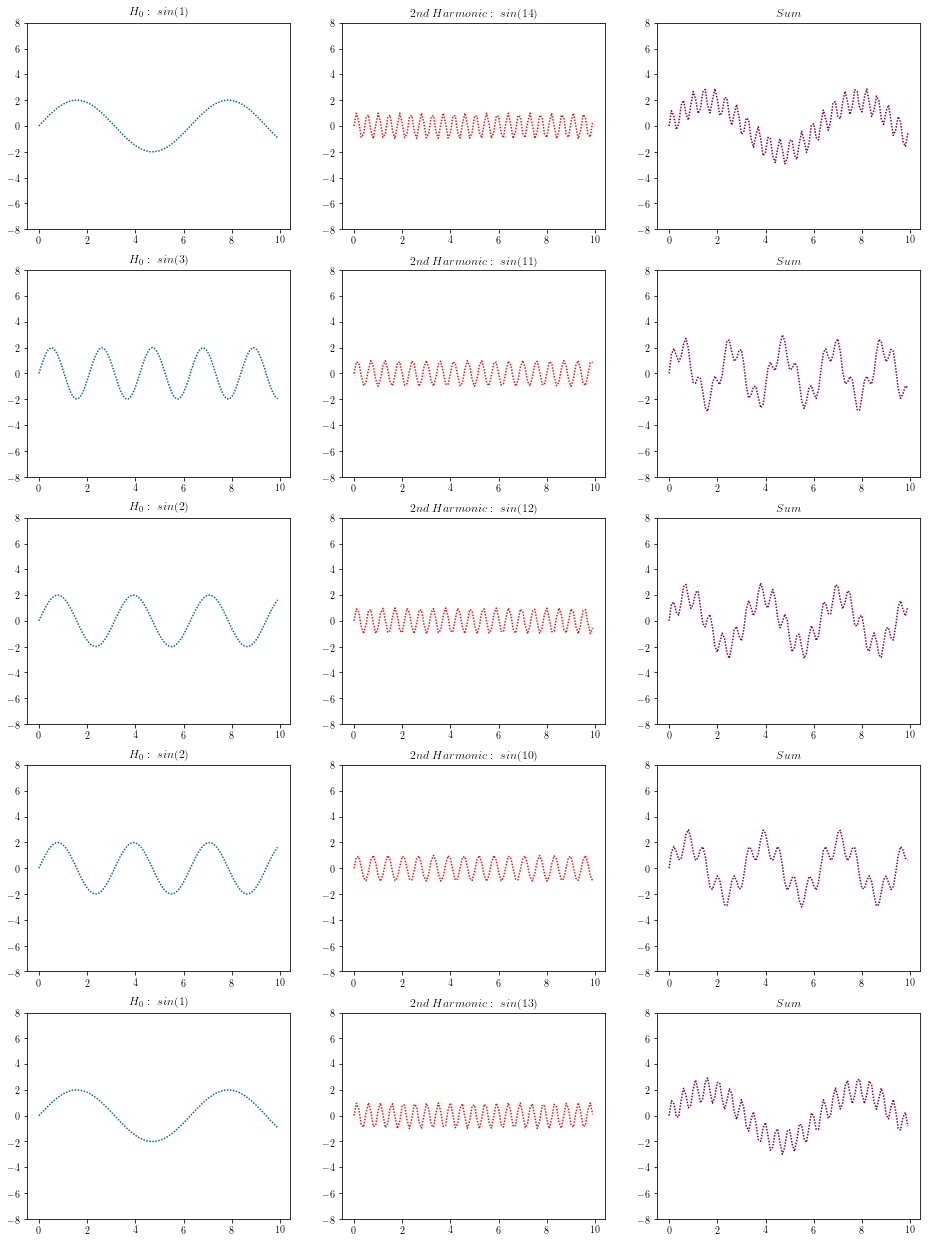

In [130]:

fig, axes = plt.subplots(nrows=5,ncols=3,figsize=(16,22))


x = np.arange(0,10, 0.1)


# generative process in real world
# a, b = 1, 10
# y = np.sin(a * x) + np.sin(b * x)



training_samples = []

# let's take some samples from 'the real world'
for a in range(5):
    w1, w2 = np.random.randint(1, 4), np.random.randint(5, 15)
    h0 = 2 * np.sin(w1*x)
    h1 = np.sin(w2 * x)
    y =  h0 + h1
#         y = w1 * np.sin(w2 * x)
#     for b in range(3):
#         r = np.random.randint(1, 10, size=2)
    training_samples.append(torch.unsqueeze(torch.unsqueeze(torch.Tensor(y), 0),0))


    axes[a][0].plot(x, h0,linestyle = (0, (1,1)), color = '#086788')
    axes[a][1].plot(x, h1,linestyle = (0, (1,1)), color = '#DD1C1A')
    axes[a][2].plot(x, y,linestyle = (0, (1,1)), color = '#770058')

    axes[a][0].set_title(f'$H_0:\;sin({w1})$')
    axes[a][1].set_title(f'$2nd\;Harmonic:\;sin({w2})$')
    axes[a][2].set_title(f'$Sum$')

# #         axes[a][b].set_title(f'Generating Factors: {np.mean(y):.4f}')

    axes[a][0].set_ylim(-8,8)
    axes[a][1].set_ylim(-8,8)
    axes[a][2].set_ylim(-8,8)



plt.show()




# training_set = torch.Tensor(training_samples)


# so theroretically, we should be able to reconstruct it given, two latent variable only...
# Note, that we don't even need a decoder, we can just use sin(z_1) + sin(z_2) (thus reaching peak interpretability :D)

In [168]:
class FHVAE(nn.Module):
    def __init__(self):
        super(FHVAE, self).__init__()
        
        # encoder/inference
        
        # z2/sequence level
        self.lstm_z2 = nn.LSTM(100,4)
        self.mlp_mean_z2 = nn.Sequential(nn.Linear(4,4), nn.ReLU(), nn.Linear(4,4))
        self.mlp_std_z2 = nn.Sequential(nn.Linear(4,4), nn.ReLU(), nn.Linear(4,4))
        
        # z1/segment level
        self.lstm_z1 = nn.LSTM(4,4)
        self.mlp_mean_z1 = nn.Sequential(nn.Linear(4,4), nn.ReLU(), nn.Linear(4,4))
        self.mlp_std_z1 = nn.Sequential(nn.Linear(4,4), nn.ReLU(), nn.Linear(4,4))
        
        
        # decoder/generative
        self.mlp_mean_x = nn.Sequential(nn.Linear(4,50), nn.ReLU(), nn.Linear(50,100))
        self.mlp_std_x = nn.Sequential(nn.Linear(4,50), nn.ReLU(), nn.Linear(50,100))
        
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps= torch.empty(mu.size()).normal_(mean=0,std=1)#.unsqueeze(0) # works quite well
        
        return mu + eps*std
    
    
    def forward(self, x):
        # encode
        # z2
        _, (h_z2, c_z2) = self.lstm_z2(x)
        
        mu_z2 = self.mlp_mean_z2(h_z2)
        std_z2 = self.mlp_std_z2(h_z2)   
        
        z2 = self.reparameterize(mu_z2, std_z2)
        
        
        # z1
        _, (h_z1, c_z1) = self.lstm_z1(z2)
        
        mu_z1 = self.mlp_mean_z1(h_z1)
        std_z1 = self.mlp_std_z1(h_z1)   
        
        z1 = self.reparameterize(mu_z1, std_z1)
        
        
        # decode
        _, (h_x, c_x) = self.lstm_z1(z1)
        mu_x = self.mlp_mean_x(h_x)
        std_x = self.mlp_std_x(h_x)  
        
        x_hat = self.reparameterize(mu_x, std_x)

        
        
        return x_hat
        
        

model = FHVAE()

# print(model)
y = model(training_samples[0])


y

tensor([[[ 0.4916,  0.8643,  0.7171, -0.3144, -1.6768, -0.0593, -1.2448,
          -0.4707,  0.7420, -0.0244,  1.2032,  0.0235, -0.1606, -0.4532,
          -0.1303, -0.3541, -0.6591, -0.0130, -1.6585, -0.5284, -0.7967,
          -0.0923, -0.8412,  0.0104,  1.2244,  1.4936,  0.4149,  1.8413,
          -1.8239,  0.2066, -1.6345, -1.4875, -1.0404, -1.2556,  0.7151,
          -0.8243,  0.0811,  0.2094, -0.2301,  0.1778, -0.1810,  0.5540,
          -0.3363,  0.5548,  0.3493,  0.7502, -0.0406, -1.4718, -1.7471,
          -1.0724, -0.1514, -0.6247,  0.4147, -0.3122,  0.5144,  0.5351,
           0.0197, -1.1691, -0.1902, -1.2716, -1.5683,  0.9735, -0.0495,
           0.2083, -0.1124, -1.4392,  0.2555,  0.1607,  1.0013,  1.7579,
           0.0824,  0.3915, -2.4646,  0.0135, -0.0653, -0.4816, -0.3997,
          -0.6856, -0.6520, -0.1272, -0.4944, -0.2737,  0.6187,  0.2831,
           0.4612, -2.2647,  0.1813, -0.4750, -0.4797, -0.3565,  0.7469,
          -0.4406, -0.7508, -1.5905, -1.6878, -0.74

In [ ]:
def loss_function(recon_x, x, mu, logvar, tau=0):
    recon_x = torch.where(torch.isnan(recon_x), torch.zeros_like(recon_x), recon_x)
    recon_x = torch.where(torch.isinf(recon_x), torch.zeros_like(recon_x), recon_x)
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum') # reconstruction loss
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) # KL-divergence from X~N(0,1)  # maybe it should be from N(0.5, 0.5)
    
    return BCE + tau * KLD